In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
data_path = './gdrive/MyDrive/Colab Notebooks/GAI_Hw4'

Mounted at /content/gdrive


In [2]:
! pip install torch
! pip install numpy
! pip install matplotlib
! pip install pillow
! pip install scikit-image
! pip install tqdm

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

In [19]:
# Define different CNN architectures for DIP
class SimpleDIPModel(nn.Module):
    def __init__(self):
        super(SimpleDIPModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 3, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

class ComplexDIPModel(nn.Module):
    def __init__(self):
        super(ComplexDIPModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(64, 3, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.conv5(x)
        return x

# Define dataset to handle noisy images
class NoisyImageDataset(Dataset):
    def __init__(self, image, noise_levels):
        self.image = image
        self.noise_levels = noise_levels

    def __len__(self):
        return len(self.noise_levels)

    def __getitem__(self, idx):
        noise_level = self.noise_levels[idx]
        noisy_image = self.image + noise_level * torch.randn_like(self.image)
        noisy_image = torch.clamp(noisy_image, 0, 1)
        return noisy_image.squeeze(0), self.image.squeeze(0)

In [20]:
# Utility functions for image processing
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))
    image = image / 255.0
    return torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32).unsqueeze(0)

def visualize_intermediate_results(target_img, noisy_img, output_img, stage, epoch, psnr, ssim):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(np.clip(target_img, 0, 1))
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title(f"Noisy (Stage {stage + 1})")
    plt.imshow(np.clip(noisy_img, 0, 1))
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title(f"DIP Output (Epoch {epoch})")
    plt.imshow(np.clip(output_img, 0, 1))
    plt.axis('off')
    plt.show()
    plt.savefig(f'stage_{stage + 1}_epoch_{epoch}.png')

def visualize_final_results(target_img, noisy_img, output_img, psnr, ssim):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(np.clip(target_img, 0, 1))
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title("Noisy")
    plt.imshow(np.clip(noisy_img, 0, 1))
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title("DIP Output")
    plt.imshow(np.clip(output_img, 0, 1))
    plt.axis('off')
    plt.show()
    plt.savefig('final_output.png')

In [21]:
def train_model(model, noisy_images_torch, target_img_torch, num_epochs_per_stage, noise_levels, target_img, noisy_images, patience=50):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    best_psnr = 0
    best_model = None
    psnr_history = []
    reconstructions = []
    ssims = []
    early_stopping_counter = 0

    for stage, noisy_img_torch in enumerate(noisy_images_torch):
        print(f"Training on stage {stage + 1} with noise level {noise_levels[stage]}")
        for epoch in tqdm(range(num_epochs_per_stage)):
            model.train()
            optimizer.zero_grad()
            output = model(noisy_img_torch)
            loss = criterion(output, target_img_torch)
            loss.backward()
            optimizer.step()

            if epoch % 10 == 0 or epoch == num_epochs_per_stage - 1:
                model.eval()
                with torch.no_grad():
                    output_img = output.squeeze().cpu().detach().numpy().transpose(1, 2, 0)
                    output_img = np.clip(output_img, 0, 1)
                    current_psnr = psnr(target_img, output_img, data_range=1.0)
                    current_ssim = ssim(target_img, output_img, data_range=1.0, channel_axis=-1)
                    psnr_history.append(current_psnr)
                    reconstructions.append(torch.tensor(output_img).permute(2, 0, 1))
                    ssims.append(current_ssim)

                    # Check for early stopping
                    if current_psnr > best_psnr:
                        best_psnr = current_psnr
                        best_model = model.state_dict()
                        early_stopping_counter = 0
                    else:
                        early_stopping_counter += 1

                    if early_stopping_counter >= patience:
                        print(f"Early stopping at stage {stage + 1}, epoch {epoch}")
                        break

            if epoch % 500 == 0 or epoch == num_epochs_per_stage - 1:
                print(f"Stage: {stage}, Epoch: {epoch}, PSNR: {current_psnr:.4f}, SSIM: {current_ssim:.4f}")

                # Visualize and save the current output image
                visualize_intermediate_results(target_img, noisy_images[stage].squeeze().numpy().transpose(1, 2, 0), output_img, stage, epoch, current_psnr, current_ssim)


        if early_stopping_counter >= patience:
            break

    return model, best_model, reconstructions, psnr_history, ssims

In [22]:
def evaluate_model(model, target_img_torch, best_model, target_img, noisy_images):
    model.load_state_dict(best_model)
    model.eval()
    with torch.no_grad():
        final_output = model(target_img_torch.unsqueeze(0)).squeeze().cpu().detach().numpy().transpose(1, 2, 0)
        final_output = np.clip(final_output, 0, 1)
        final_psnr = psnr(target_img, final_output, data_range=1.0)
        final_ssim = ssim(target_img, final_output, data_range=1.0, channel_axis=-1)
        print(f"Final PSNR: {final_psnr:.4f}, Final SSIM: {final_ssim:.4f}")

        # Visualize and save the final output image
        visualize_final_results(target_img, noisy_images[-1].squeeze().numpy().transpose(1, 2, 0), final_output, final_psnr, final_ssim)

Training on stage 1 with noise level 0.3


  0%|          | 0/1000 [00:00<?, ?it/s]

Stage: 0, Epoch: 0, PSNR: 8.3223, SSIM: 0.0305


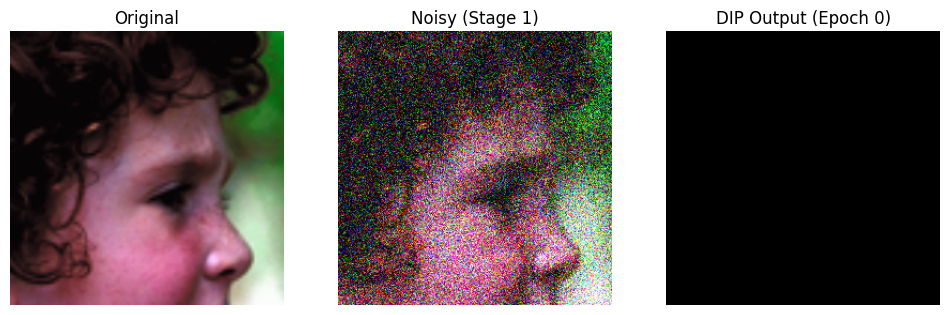

 49%|████▉     | 491/1000 [00:12<00:12, 39.55it/s]

Stage: 0, Epoch: 500, PSNR: 30.5622, SSIM: 0.8478


<Figure size 640x480 with 0 Axes>

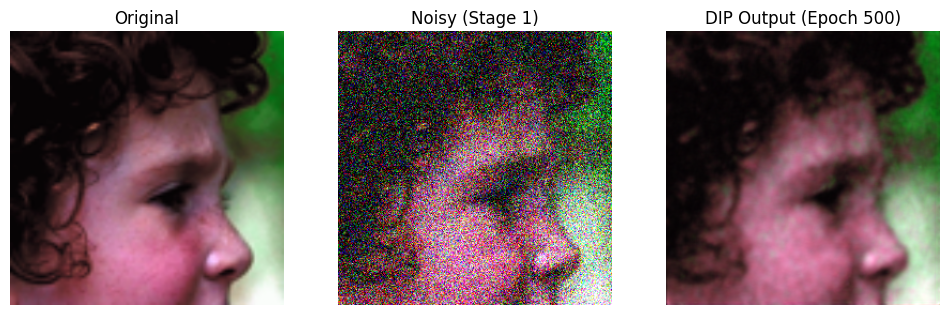

 99%|█████████▉| 991/1000 [00:25<00:00, 39.06it/s]

Stage: 0, Epoch: 999, PSNR: 32.2557, SSIM: 0.8967


<Figure size 640x480 with 0 Axes>

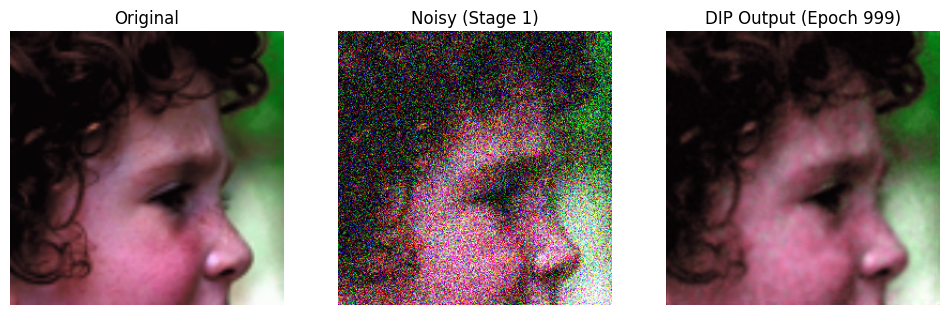

100%|██████████| 1000/1000 [00:26<00:00, 37.65it/s]


Training on stage 2 with noise level 0.2


  0%|          | 0/1000 [00:00<?, ?it/s]

Stage: 1, Epoch: 0, PSNR: 28.8463, SSIM: 0.8241


<Figure size 640x480 with 0 Axes>

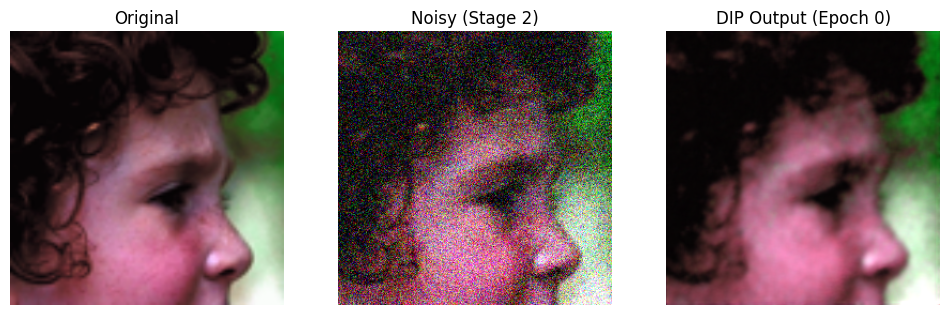

  5%|▌         | 50/1000 [00:01<00:33, 28.61it/s]

Early stopping at stage 2, epoch 50
Final PSNR: 30.7375, Final SSIM: 0.8801


<Figure size 640x480 with 0 Axes>

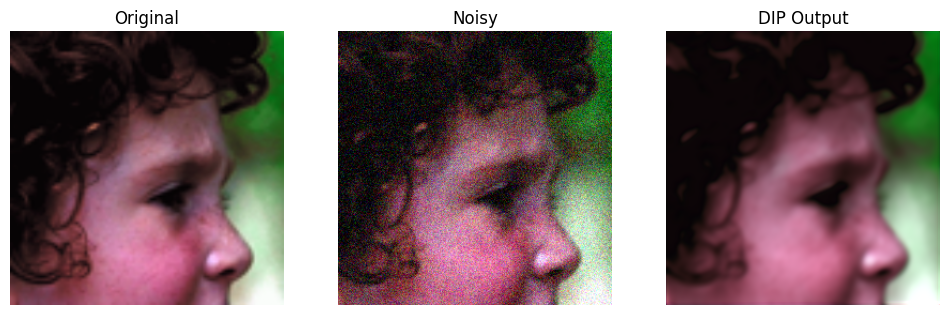

<Figure size 640x480 with 0 Axes>

In [23]:
def main(image_path, noise_levels, num_epochs_per_stage, patience):
    target_image = load_image(image_path)
    target_img_torch = target_image.squeeze(0).cuda()
    target_img = target_img_torch.cpu().numpy().transpose(1, 2, 0)

    # Create noisy images for each noise level
    noisy_images = [target_image + nl * torch.randn_like(target_image) for nl in noise_levels]
    noisy_images_torch = [torch.clamp(noisy_img, 0, 1).squeeze(0).cuda() for noisy_img in noisy_images]

    # Initialize the DIP model
    model = ComplexDIPModel().cuda()

    # Train the model
    model, best_model, reconstructions, psnr_history, ssims = train_model(
        model, noisy_images_torch, target_img_torch, num_epochs_per_stage, noise_levels, target_img, noisy_images, patience
    )

    # Evaluate the model
    evaluate_model(model, target_img_torch, best_model, target_img, noisy_images)

if __name__ == "__main__":
    image_path = data_path + '/img_006_SRF_3_LR.png'
    noise_levels = [0.3, 0.2, 0.1]  # Different noise levels
    epochs_per_stage = 1000
    patience = 10  # Early stopping patience
    main(image_path, noise_levels, epochs_per_stage, patience)